In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("datasets/application_train.csv")
df.groupby('TARGET')['TARGET'].count()

TARGET
0    282686
1     24825
Name: TARGET, dtype: int64

In [3]:
def missing_val_tab(df):
    missing_values_df = pd.DataFrame(columns=['features', "missings_values_%"])
    for c in df.columns: 
       col = df[c]           
       missing_values_df = missing_values_df.append({
           "features":c, 
           "missings_values_%":col.isna().sum()*100/col.size}, ignore_index=True)
    return missing_values_df

In [4]:
miss_val_df = missing_val_tab(df)
print(miss_val_df.sort_values("missings_values_%", ascending=False).head(20))

                    features  missings_values_%
76           COMMONAREA_MEDI          69.872297
48            COMMONAREA_AVG          69.872297
62           COMMONAREA_MODE          69.872297
70  NONLIVINGAPARTMENTS_MODE          69.432963
56   NONLIVINGAPARTMENTS_AVG          69.432963
84  NONLIVINGAPARTMENTS_MEDI          69.432963
86        FONDKAPREMONT_MODE          68.386172
68     LIVINGAPARTMENTS_MODE          68.354953
54      LIVINGAPARTMENTS_AVG          68.354953
82     LIVINGAPARTMENTS_MEDI          68.354953
52             FLOORSMIN_AVG          67.848630
66            FLOORSMIN_MODE          67.848630
80            FLOORSMIN_MEDI          67.848630
75          YEARS_BUILD_MEDI          66.497784
61          YEARS_BUILD_MODE          66.497784
47           YEARS_BUILD_AVG          66.497784
21               OWN_CAR_AGE          65.990810
81             LANDAREA_MEDI          59.376738
67             LANDAREA_MODE          59.376738
53              LANDAREA_AVG          59

There is a lot of features containing a lot of null values. So, we delete features with more than 20% of null values, because they will not be significant for ours models

In [5]:
del_cols = [col for col in df if (df[col].isna().sum()/df[col].size) > 0.2]
df = df.drop(columns=del_cols)

We delete rows with at least one null value in the categorical features (we lost few data)

In [6]:
cat_vars = [c for c in df if df[c].dtype == "object"]
print(df.shape)
df = df.dropna(axis=0, how='any', subset=cat_vars)
print(df.shape)

(307511, 72)
(306219, 72)


We encode categorical features with a label encoder for features with only 2 values and a one hot encoding for the others

In [7]:
le = LabelEncoder()
label_encoded_vars = []
dummies_vars = []
for cat in cat_vars:
    if df[cat].nunique() <= 2:
        df[cat] = le.fit_transform(df[cat])
        label_encoded_vars.append(cat)
    else:
        dummies_vars.append(cat)
df_cat = pd.concat(
    [
        df[label_encoded_vars],
        pd.get_dummies(df[dummies_vars])
    ]
    ,axis=1)

We replace null values in each numerical feature by the mean of the feature

In [8]:
df_num = df.drop(columns=cat_vars)
df_num = df_num.fillna(df_num.mean())
df = pd.concat([df_num, df_cat], axis=1)

In [9]:
y = df.TARGET
X = df.drop(columns="TARGET")

In [10]:
del df
del df_cat
del df_num
del miss_val_df

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
del X
del y

In [12]:
model_rfc = RandomForestClassifier(n_jobs=-1)
model_rfc.fit(X=X_train, y=y_train)
y_pred_rfc = model_rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.60      0.00      0.00      8246

    accuracy                           0.92    101053
   macro avg       0.76      0.50      0.48    101053
weighted avg       0.89      0.92      0.88    101053

[[92803     4]
 [ 8240     6]]


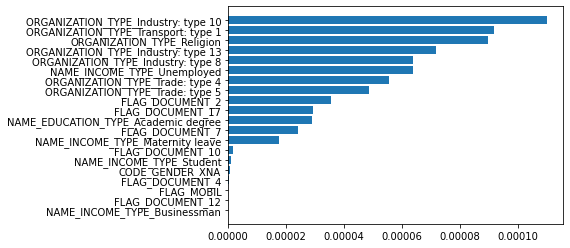

In [13]:
print(classification_report(y_test, y_pred_rfc))
print(confusion_matrix(y_test, y_pred_rfc))
feat_imp_df = pd.DataFrame({"features": X_train.columns, "importance": model_rfc.feature_importances_}).sort_values("importance").head(20)
plt.barh(feat_imp_df.features, feat_imp_df.importance)
plt.show()

In [14]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X=X_train, y=y_train)
y_pred_gbc = model_gbc.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred_gbc))
print(confusion_matrix(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.58      0.01      0.03      8246

    accuracy                           0.92    101053
   macro avg       0.75      0.51      0.49    101053
weighted avg       0.89      0.92      0.88    101053

[[92727    80]
 [ 8137   109]]


In [16]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     92807
           1       0.47      0.03      0.05      8246

    accuracy                           0.92    101053
   macro avg       0.69      0.51      0.50    101053
weighted avg       0.88      0.92      0.88    101053

[[92554   253]
 [ 8023   223]]


In [18]:
shap.initjs()

In [20]:
explainer = shap.TreeExplainer(model_xgb)

In [21]:
observations = X_train.sample(1000, random_state=42).to_numpy()
shap_values = explainer.shap_values(observations)

In [23]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i],features=observations[i], feature_names=X_train.columns)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, features=observations, feature_names=X_train.columns)

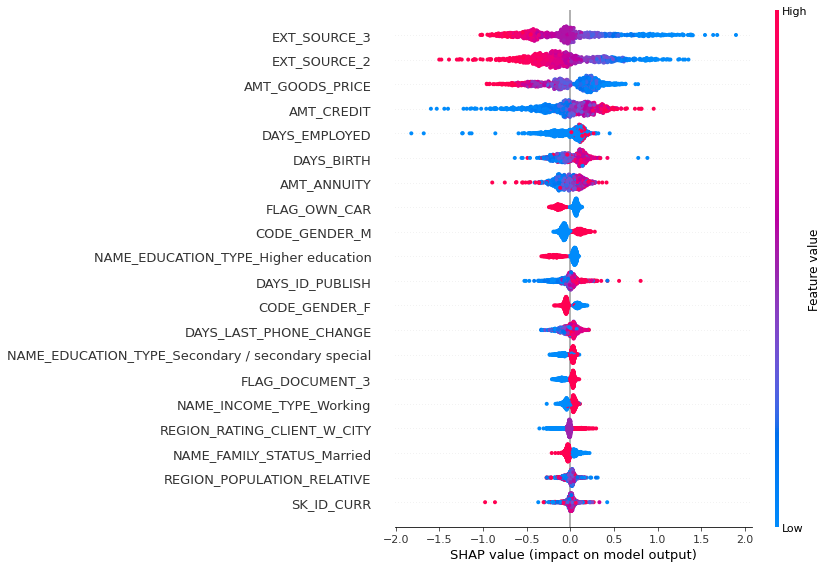

In [25]:
shap.summary_plot(shap_values, features=observations, feature_names=X_train.columns)